In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
IMAGE_PATH = '../FloodNet_large/imgs/'
MASK_PATH = '../FloodNet_large/labels/'

In [3]:
n_classes = 10

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  2343


In [4]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  1791
Val Size     :  317
Test Size    :  235


Image Size (3000, 4000, 3)
Mask Size (3000, 4000)


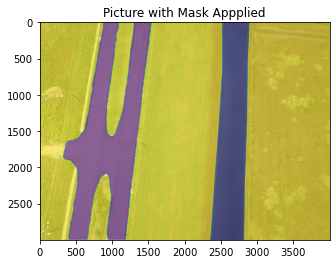

In [5]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '_lab.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [6]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '_lab.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [7]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704 ,1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704 ,1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 1 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)  

In [10]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  SFNet
    3  BiSeNetv1
    4  DDRNet
    5  FCHarDNet
    6  BiSeNetv2


In [12]:
from semseg.models import *

model = eval('BiSeNetv2')(
#     backbone='MobileNetV3',
    num_classes=10
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map_location='cpu'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()

print('Loaded Model')

Download a pretrained model's weights from the result table.
Loaded Model


In [16]:
import torch
import math
from torch import nn, Tensor
from torch.nn import functional as F
# from .modules.common import ConvModule
import torch
from torch import nn, Tensor


class ConvModule(nn.Sequential):
    def __init__(self, c1, c2, k, s=1, p=0, d=1, g=1):
        super().__init__(
            nn.Conv2d(c1, c2, k, s, p, d, g, bias=False),
            nn.BatchNorm2d(c2),
            nn.ReLU(True)
        )

class DetailBranch(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.S1 = nn.Sequential(
            ConvModule(3, 64, 3, 2, 1),
            ConvModule(64, 64, 3, 1, 1)
        )
        self.S2 = nn.Sequential(
            ConvModule(64, 64, 3, 2, 1),
            ConvModule(64, 64, 3, 1, 1),
            ConvModule(64, 64, 3, 1, 1)
        )
        self.S3 = nn.Sequential(
            ConvModule(64, 128, 3, 2, 1),
            ConvModule(128, 128, 3, 1, 1),
            ConvModule(128, 128, 3, 1, 1)
        )

    def forward(self, x):
        return self.S3(self.S2(self.S1(x)))


class StemBlock(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv_3x3 = ConvModule(3, 16, 3, 2, 1)
        self.left = nn.Sequential(
            ConvModule(16, 8, 1, 1, 0),            
            ConvModule(8, 16, 3, 2, 1)
        )
        self.right = nn.MaxPool2d(3, 2, 1, ceil_mode=False)
        self.fuse = ConvModule(32, 16, 3, 1, 1)

    def forward(self, x):
        x = self.conv_3x3(x)
        x_left = self.left(x)
        x_right = self.right(x)
        y = torch.cat([x_left, x_right], dim=1)
        return self.fuse(y)


class ContextEmbeddingBlock(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.inner = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.BatchNorm2d(128),
            ConvModule(128, 128, 1, 1, 0)           
        )
        self.conv = ConvModule(128, 128, 3, 1, 1)   

    def forward(self, x):
        y = self.inner(x)
        out = x + y
        return self.conv(out)


class GatherExpansionLayerv1(nn.Module):
    def __init__(self, in_ch, out_ch, e=6) -> None:
        super().__init__()
        self.inner = nn.Sequential(
            ConvModule(in_ch, in_ch, 3, 1, 1),
            ConvModule(in_ch, in_ch*e, 3, 1, 1, g=in_ch),  
            nn.Conv2d(in_ch*e, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        y = self.inner(x)
        out = x + y
        return self.relu(out)


class GatherExpansionLayerv2(nn.Module):
    def __init__(self, in_ch, out_ch, e=6) -> None:
        super().__init__()
        self.inner = nn.Sequential(
            ConvModule(in_ch, in_ch, 3, 1, 1),
            nn.Conv2d(in_ch, in_ch*e, 3, 2, 1, groups=in_ch, bias=False),
            nn.BatchNorm2d(in_ch*e),
            ConvModule(in_ch*e, in_ch*e, 3, 1, 1, g=in_ch*e),               
            nn.Conv2d(in_ch*e, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch)
        )

        self.outer = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, 2, 1, groups=in_ch, bias=False),
            nn.BatchNorm2d(in_ch),
            nn.Conv2d(in_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch)
        )

        self.relu = nn.ReLU(True)

    def forward(self, x):
        x1 = self.inner(x)
        x2 = self.outer(x)
        out = x1 + x2
        return self.relu(out)


class SemanticBranch(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.S1S2 = StemBlock()
        self.S3 = nn.Sequential(
            GatherExpansionLayerv2(16, 32),
            GatherExpansionLayerv1(32, 32)
        )
        self.S4 = nn.Sequential(
            GatherExpansionLayerv2(32, 64),
            GatherExpansionLayerv1(64, 64)
        )
        self.S5_1 = nn.Sequential(
            GatherExpansionLayerv2(64, 128),
            GatherExpansionLayerv1(128, 128),
            GatherExpansionLayerv1(128, 128),
            GatherExpansionLayerv1(128, 128)
        )
        self.S5_2 = ContextEmbeddingBlock()

    def forward(self, x):
        x2 = self.S1S2(x)
        x3 = self.S3(x2)
        x4 = self.S4(x3)
        x5_1 = self.S5_1(x4)
        x5_2 = self.S5_2(x5_1)
        return x2, x3, x4, x5_1, x5_2


class AggregationLayer(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.left1 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1, groups=128, bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 1, 1, 0, bias=False)
        )
        self.left2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.AvgPool2d(3, 2, 1, ceil_mode=False)
        )

        self.right1 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=4),
            nn.Sigmoid()
        )
        self.right2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1, groups=128, bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.up = nn.Upsample(scale_factor=4)           
        self.conv = ConvModule(128, 128, 3, 1, 1)       


    def forward(self, x_d, x_s):
        x1 = self.left1(x_d)
        x2 = self.left2(x_d)
        x3 = self.right1(x_s)
        x4 = self.right2(x_s)

        left = x1 * x3
        right = x2 * x4
        right = self.up(right)
        out = left + right

        return self.conv(out)


class SegHead(nn.Module):
    def __init__(self, in_ch, mid_ch, num_classes, upscale_factor=8, is_aux=True) -> None:
        super().__init__()
        out_ch = num_classes * upscale_factor * upscale_factor

        self.conv_3x3 = ConvModule(in_ch, mid_ch, 3, 1, 1)
        self.drop = nn.Dropout(0.1)

        if is_aux:
            self.conv_out = nn.Sequential(
                ConvModule(mid_ch, upscale_factor * upscale_factor, 3, 1, 1),
                nn.Conv2d(upscale_factor*upscale_factor, out_ch, 1, 1, 0),
                nn.PixelShuffle(upscale_factor)
            )
        else:
            self.conv_out = nn.Sequential(
                nn.Conv2d(mid_ch, out_ch, 1, 1, 0),
                nn.PixelShuffle(upscale_factor)
            )

    def forward(self, x):
        out = self.conv_3x3(x)
        out = self.drop(out)
        return self.conv_out(out)


class BiSeNetv2(nn.Module):
    def __init__(self, backbone: str = None, num_classes: int = 19) -> None:
        super().__init__()
        self.detail_branch = DetailBranch()
        self.semantic_branch = SemanticBranch()
        self.aggregation_layer = AggregationLayer()

        self.output_head = SegHead(128, 1024, num_classes, upscale_factor=8, is_aux=False)

        self.aux2_head = SegHead(16, 128, num_classes, upscale_factor=4)
        self.aux3_head = SegHead(32, 128, num_classes, upscale_factor=8)
        self.aux4_head = SegHead(64, 128, num_classes, upscale_factor=16)
        self.aux5_head = SegHead(128, 128, num_classes, upscale_factor=32)

        self.apply(self._init_weights)

    def _init_weights(self, m: nn.Module) -> None:
        if isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out // m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, (nn.LayerNorm, nn.BatchNorm2d)):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def init_pretrained(self, pretrained: str = None) -> None:
        pass

    def forward(self, x):
        x_d = self.detail_branch(x)
        aux2, aux3, aux4, aux5, x_s = self.semantic_branch(x)

        output = self.aggregation_layer(x_d, x_s)
        output = self.output_head(output)

        if self.training:
            aux2 = self.aux2_head(aux2)
            aux3 = self.aux3_head(aux3)
            aux4 = self.aux4_head(aux4)
            aux5 = self.aux5_head(aux5)
            return output, aux2, aux3, aux4, aux5
        return output



model = BiSeNetv2()
model.eval()

BiSeNetv2(
  (detail_branch): DetailBranch(
    (S1): Sequential(
      (0): ConvModule(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): ConvModule(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (S2): Sequential(
      (0): ConvModule(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): ConvModule(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [17]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [18]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            model.eval()
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'hardnet_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [20]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/1791 [00:00<?, ?it/s]

C:\Users\fsafavi1\Anaconda3\envs\py37\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/317 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.153 
Epoch:1/30.. Train Loss: 1.289.. Val Loss: 1.153.. Train mIoU:0.236.. Val mIoU: 0.279.. Train Acc:0.559.. Val Acc:0.590.. Time: 9.99m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Decreasing.. 1.153 >> 1.050 
Epoch:2/30.. Train Loss: 1.056.. Val Loss: 1.050.. Train mIoU:0.336.. Val mIoU: 0.374.. Train Acc:0.617.. Val Acc:0.612.. Time: 9.76m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/30.. Train Loss: 0.958.. Val Loss: 1.075.. Train mIoU:0.400.. Val mIoU: 0.343.. Train Acc:0.658.. Val Acc:0.618.. Time: 9.81m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Decreasing.. 1.075 >> 1.044 
Epoch:4/30.. Train Loss: 0.936.. Val Loss: 1.044.. Train mIoU:0.406.. Val mIoU: 0.365.. Train Acc:0.664.. Val Acc:0.571.. Time: 9.77m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Decreasing.. 1.044 >> 0.886 
saving model...
Epoch:5/30.. Train Loss: 0.907.. Val Loss: 0.886.. Train mIoU:0.423.. Val mIoU: 0.404.. Train Acc:0.681.. Val Acc:0.689.. Time: 9.81m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:6/30.. Train Loss: 0.988.. Val Loss: 0.966.. Train mIoU:0.373.. Val mIoU: 0.353.. Train Acc:0.654.. Val Acc:0.632.. Time: 9.86m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Decreasing.. 0.966 >> 0.955 
Epoch:7/30.. Train Loss: 1.128.. Val Loss: 0.955.. Train mIoU:0.318.. Val mIoU: 0.363.. Train Acc:0.617.. Val Acc:0.656.. Time: 9.86m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Decreasing.. 0.955 >> 0.836 
Epoch:8/30.. Train Loss: 0.965.. Val Loss: 0.836.. Train mIoU:0.382.. Val mIoU: 0.435.. Train Acc:0.660.. Val Acc:0.705.. Time: 9.82m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:9/30.. Train Loss: 0.946.. Val Loss: 1.296.. Train mIoU:0.391.. Val mIoU: 0.390.. Train Acc:0.667.. Val Acc:0.675.. Time: 9.77m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Decreasing.. 1.296 >> 0.826 
Epoch:10/30.. Train Loss: 0.871.. Val Loss: 0.826.. Train mIoU:0.428.. Val mIoU: 0.432.. Train Acc:0.695.. Val Acc:0.712.. Time: 9.89m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Decreasing.. 0.826 >> 0.806 
Epoch:11/30.. Train Loss: 0.881.. Val Loss: 0.806.. Train mIoU:0.427.. Val mIoU: 0.462.. Train Acc:0.694.. Val Acc:0.722.. Time: 9.76m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:12/30.. Train Loss: 0.873.. Val Loss: 0.885.. Train mIoU:0.434.. Val mIoU: 0.417.. Train Acc:0.699.. Val Acc:0.700.. Time: 9.77m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Decreasing.. 0.885 >> 0.750 
saving model...
Epoch:13/30.. Train Loss: 0.822.. Val Loss: 0.750.. Train mIoU:0.448.. Val mIoU: 0.462.. Train Acc:0.713.. Val Acc:0.739.. Time: 9.79m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:14/30.. Train Loss: 0.785.. Val Loss: 0.761.. Train mIoU:0.473.. Val mIoU: 0.441.. Train Acc:0.728.. Val Acc:0.728.. Time: 9.80m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Decreasing.. 0.761 >> 0.759 
Epoch:15/30.. Train Loss: 0.729.. Val Loss: 0.759.. Train mIoU:0.492.. Val mIoU: 0.478.. Train Acc:0.746.. Val Acc:0.738.. Time: 9.80m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Decreasing.. 0.759 >> 0.718 
Epoch:16/30.. Train Loss: 0.735.. Val Loss: 0.718.. Train mIoU:0.493.. Val mIoU: 0.491.. Train Acc:0.747.. Val Acc:0.746.. Time: 9.78m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:17/30.. Train Loss: 0.710.. Val Loss: 0.736.. Train mIoU:0.503.. Val mIoU: 0.464.. Train Acc:0.755.. Val Acc:0.744.. Time: 9.82m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Decreasing.. 0.736 >> 0.674 
Epoch:18/30.. Train Loss: 0.677.. Val Loss: 0.674.. Train mIoU:0.519.. Val mIoU: 0.500.. Train Acc:0.767.. Val Acc:0.767.. Time: 9.79m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Decreasing.. 0.674 >> 0.607 
Epoch:19/30.. Train Loss: 0.655.. Val Loss: 0.607.. Train mIoU:0.532.. Val mIoU: 0.529.. Train Acc:0.775.. Val Acc:0.790.. Time: 9.80m


  0%|          | 0/1791 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 196.24 m


In [21]:
torch.save(model, 'BiseNetV2.pt')

In [22]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

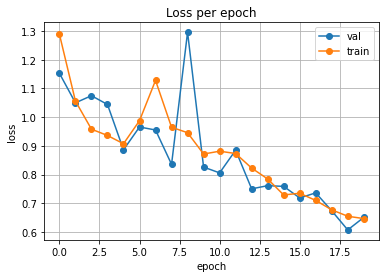

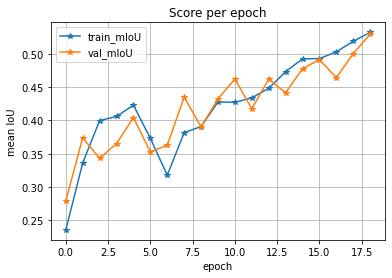

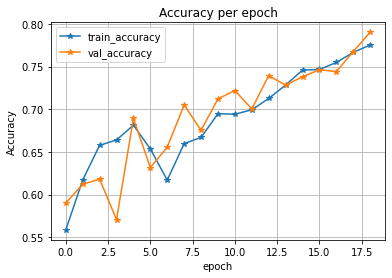

In [23]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [24]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '_lab.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(704 ,1056, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [25]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [26]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [27]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [28]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [29]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/235 [00:00<?, ?it/s]

In [30]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [31]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/235 [00:00<?, ?it/s]

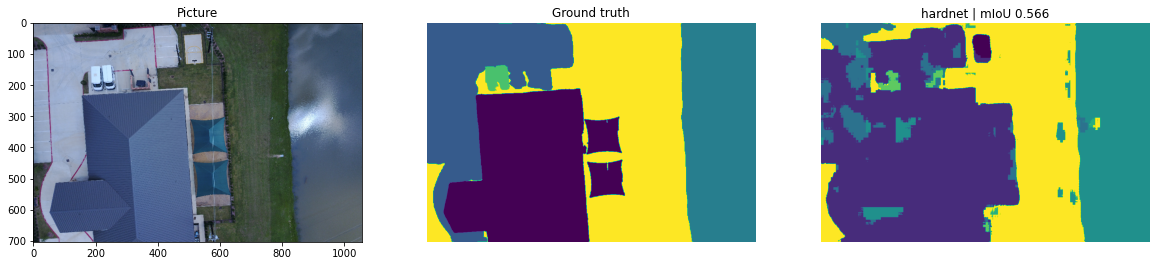

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('hardnet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

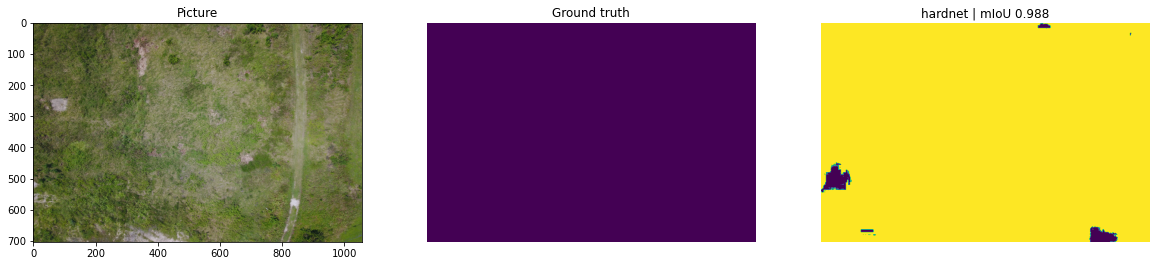

In [33]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('hardnet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

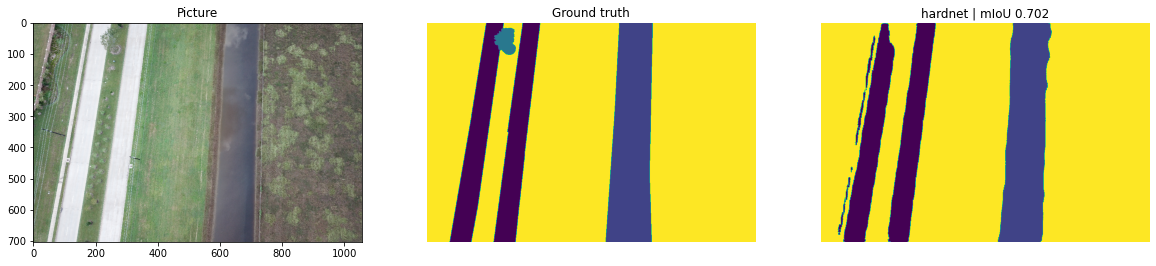

In [34]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('hardnet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [35]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.5352857800034281


In [36]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.7843521099382363
